<a href="https://colab.research.google.com/github/mayanjabbaale/Facial-Emotion-Recognition/blob/main/Facial_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchinfo
import os
from google.colab import files
files.upload()


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
import kagglehub

path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fer2013' dataset.
Path to dataset files: /kaggle/input/fer2013


In [4]:
train_path = os.path.join(path, 'train')
test_path = os.path.join(path, 'test')

train_path, test_path

('/kaggle/input/fer2013/train', '/kaggle/input/fer2013/test')

In [5]:
from torchvision.datasets import ImageFolder
import PIL.Image as Image
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

torch.manual_seed(54)
torch.cuda.manual_seed_all(54)

model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
model_transforms = MobileNet_V3_Small_Weights.DEFAULT.transforms()

weights = MobileNet_V3_Small_Weights.DEFAULT
mean = model_transforms.mean
std = model_transforms.std

train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((96, 96)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_data = ImageFolder(train_path, transform=train_transforms)
test_data = ImageFolder(test_path, transform=test_transforms)

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

imgs, labels = next(iter(train_dataloader))
class_names = train_data.classes


img, label = train_data[0]
img.shape, class_names[label]

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 130MB/s]


(torch.Size([3, 96, 96]), 'angry')

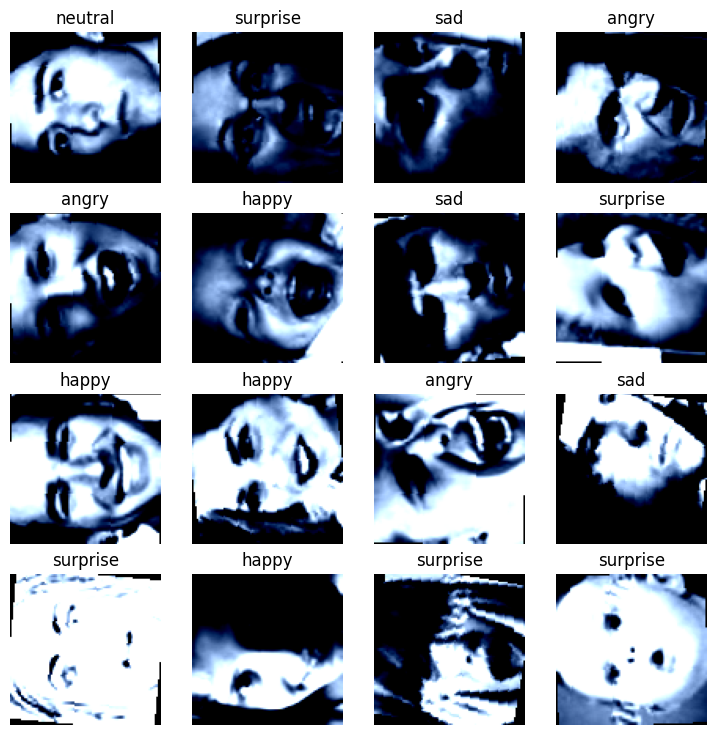

In [6]:
import matplotlib.pyplot as plt
import random
import torch

# Plot more images
# torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(2,1,0), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

In [7]:
from torchinfo import summary

for param in model.features.parameters():
    param.requires_grad = False

model.classifier[3] = nn.Linear(in_features=1024, out_features=7, bias=True)

model_summary = summary(model, input_size=[1, 3, 98, 98], col_names=['trainable'])
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [8]:
import torchvision.models as models
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from timeit import default_timer as timer

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)

epochs = 20
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def train_step(dataloader, model, loss_fn, optimizer, device):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_logits = model(X)
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        y_pred = torch.softmax(y_logits, dim=1).argmax(1)
        acc = accuracy_fn(y_true=y, y_pred=y_pred)
        train_acc += acc

    avg_loss = train_loss / len(dataloader)
    accuracy = train_acc / len(dataloader)
    return avg_loss, accuracy

def test_step(dataloader, model, loss_fn, device):
    model.eval() # Set model to evaluation mode
    test_loss, test_acc = 0, 0
    with torch.inference_mode(): # Disable gradient calculation for inference
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            y_logits = model(X)
            loss = loss_fn(y_logits, y)
            test_loss += loss.item()

            y_pred = torch.softmax(y_logits, dim=1).argmax(1)
            acc = accuracy_fn(y_true=y, y_pred=y_pred)
            test_acc += acc

    avg_loss = test_loss / len(dataloader)
    accuracy = test_acc / len(dataloader)
    return avg_loss, accuracy

start_time = timer()
for epoch in range(epochs):
    train_loss, train_acc = train_step(train_dataloader, model, loss_fn, optimizer, device)
    test_loss, test_acc = test_step(test_dataloader, model, loss_fn, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

end_time = timer()
train_time = end_time - start_time

print("Training complete!")
if train_time < 60:
  print(f'Trained for {train_time:.3f} seconds')
else:
  train_time = train_time / 60.0
  print(f'Trained for {train_time:.3f} minutes')

torch.save(obj=model.state_dict(), f="facial_emotion_model.pth")

Using cuda device
Epoch 1/20 | Train Loss: 1.7288 | Train Acc: 30.79% | Test Loss: 1.6465 | Test Acc: 34.45%
Epoch 2/20 | Train Loss: 1.6417 | Train Acc: 35.50% | Test Loss: 1.6083 | Test Acc: 36.41%
Epoch 3/20 | Train Loss: 1.6189 | Train Acc: 36.79% | Test Loss: 1.5868 | Test Acc: 37.38%
Epoch 4/20 | Train Loss: 1.5985 | Train Acc: 37.30% | Test Loss: 1.5751 | Test Acc: 38.54%
Epoch 5/20 | Train Loss: 1.5850 | Train Acc: 38.09% | Test Loss: 1.5556 | Test Acc: 39.08%
Epoch 6/20 | Train Loss: 1.5810 | Train Acc: 37.88% | Test Loss: 1.5522 | Test Acc: 38.70%
Epoch 7/20 | Train Loss: 1.5708 | Train Acc: 38.41% | Test Loss: 1.5451 | Test Acc: 39.66%
Epoch 8/20 | Train Loss: 1.5561 | Train Acc: 39.23% | Test Loss: 1.5373 | Test Acc: 39.70%
Epoch 9/20 | Train Loss: 1.5496 | Train Acc: 39.28% | Test Loss: 1.5356 | Test Acc: 39.94%
Epoch 10/20 | Train Loss: 1.5405 | Train Acc: 40.11% | Test Loss: 1.5309 | Test Acc: 39.94%
Epoch 11/20 | Train Loss: 1.5401 | Train Acc: 39.73% | Test Loss: 1.528

In [9]:
!ls

facial_emotion_model.pth  kaggle.json  sample_data


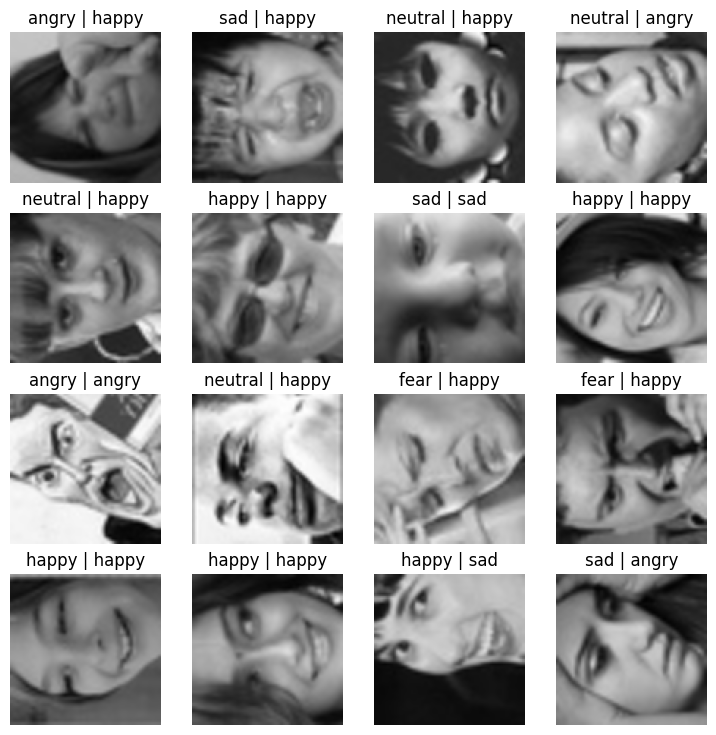

In [10]:
pred_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((96,96))
])
train_data = ImageFolder(train_path, transform=pred_transforms)
model.eval()
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    logits = model(img.unsqueeze(0).to(device))
    pred_class = class_names[torch.softmax(logits, 1).argmax(1).item()]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(2,1,0), cmap="gray")
    plt.title(f'{class_names[label]} | {pred_class}')
    plt.axis(False);

In [11]:
import gradio as gr

In [12]:
def predict_image(image):
    predict_transforms_pil = transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    img_tensor = predict_transforms_pil(image).unsqueeze(0).to(device)

    model.eval()
    with torch.inference_mode():
        logits = model(img_tensor)

    probabilities = torch.softmax(logits, dim=1)
    predicted_class_idx = probabilities.argmax(1).item()

    predictions = {class_names[i]: float(probabilities[0][i]) for i in range(len(class_names))}

    return predictions

interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil", label="Upload an Image"),
    outputs=gr.Label(num_top_classes=7, label='Predictions'),
    title="Facial Emotion Recognition",
    description="Upload an image of a face to predict the emotion.",
    examples=[
        # Add example images here if you have any
        # For example: "path/to/angry_face.jpg",
        # "path/to/happy_face.jpg"
    ]
)

interface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://541c72cbb91a0e95d5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
